## Probabilistic Programming 2: Message Passing & Analytical Bayesian Solutions

#### Goal 
  - Understand when and how analytical solutions to Bayesian inference can be obtained.
  - Understand how to perform message passing in a Forney-style factor graph.

#### Materials        
  - Mandatory
    - This notebook
    - Lecture notes on factor graphs
    - Lecture notes on continuous data
    - Lecture notes on discrete data
  - Optional
    - Chapters 2 and 3 of [Model-Based Machine Learning](http://www.mbmlbook.com/LearningSkills.html).
    - [Differences between Julia and Matlab / Python](https://docs.julialang.org/en/v1/manual/noteworthy-differences/index.html).

Note that none of the material used below is new. The point of the Probabilistic Programming sessions is to solve practical problems so that the concepts introduced in Bert's lectures become less abstract.

In [88]:
using LinearAlgebra
using SpecialFunctions
using ForneyLab
using Plots

We'll be using the toolbox [ForneyLab.jl](https://github.com/biaslab/ForneyLab.jl) to visualize factor graphs and compute messages passed within the graph.

## Problem: A Job Interview

When you finish your master's degree, you will need to start looking for jobs. You will get one or more job interviews and some will be fun while others be frustrating. The company you applied wants a talented and skilled employee, but measuring a person's skill is tricky. Even a highly-skilled person makes mistakes and people with little skills can get lucky. In this session, we will looking at various ways to assess skill using questions and test assignments. Along the way, you will gain experience with message passing, factor graphs and discrete vs continuous data.

### 1: Right or wrong

Suppose you head to a job interview for a machine learning engineer position. The company is interested in someone who knows Julia and has set up a test with syntax questions. We will first look at a single question, which we treat as an outcome variable $X_1$. You can either get this question right or wrong, which means we're dealing with a Bernoulli likelihood. The company assumes you have a skill level, denoted $\theta$, and the higher the skill, the more likely you are to get the question right. Since the company doesn't know anything about you, they chose an uninformative prior distribution: the _Beta(1,1)_. We can write the generative model for answering this question as follows:

$$\begin{align}
p(X_1, \theta) = p(X_1 \mid \theta) \cdot p(\theta)
\end{align}$$

where $p(X_1 \mid \theta) = \text{Bern}(X_1 \mid \theta)$ and $p(\theta) = \text{Beta}(\theta \mid 1,1)$. We can write this as the following factor graph.

todo: image factor graph

Fortunately, you don't have to do this by hand everytime. We can map this model to a Forney-style factor graph using the toolbox ForneyLab.

In [89]:
# Start building a model by setting up a FactorGraph structure
factor_graph1 = FactorGraph()

# Add the prior over 
@RV θ ~ Beta(1.0, 1.0, id=:prior)

# Add the question correctness likelihood
@RV X1 ~ Bernoulli(θ, id=:likelihood)

# The outcome X1 is going to be observed, so we set up a placeholder for the data entry
placeholder(X1, :X1)

# Visualize the graph
ForneyLab.draw(factor_graph1)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 8027428681881308551 -->
 
 8027428681881308551 
 
 clamp_1 
 
<!-- 2134885403931286204 -->
 
 2134885403931286204 
 
 Ber 
 likelihood 
 
<!-- 2101607915701908730 -->
 
 2101607915701908730 
 
 Beta 
 prior 
 
<!-- 2134885403931286204--2101607915701908730 -->
 
 2134885403931286204--2101607915701908730 
 
 θ 
 1 out 
 2 p 
 
<!-- 11578878984592803018 -->
 
 11578878984592803018 
 
 clamp_2 
 
<!-- 1822884904902011842 -->
 
 1822884904902011842 
 
 placeholder_X1 
 
<!-- 1822884904902011842--2134885403931286204 -->
 
 1822884904902011842--2134885403931286204 
 
 X1 
 1 out 
 1 out 
 
<!-- 2101607915701908730--8027428681881308551 -->
 
 2101607915701908730--8027428681881308551 
 
 clamp_1 
 1 out 
 2 a 
 
<!-- 2101607915701908730--11578878984592803018 -->
 
 2101607915701908730--11578878984592803018 
 
 clamp_2 
 1 out 
 3 b

Code notes:
- @RV is a macro that lets you Random Variables as nodes to your factor graph.
- The symbol ~ means "is distributed as". For example, $\theta \sim \text{Beta}(1,1)$ should be read as $\theta$ is distributed as a Beta(1,1) distribution.

Above you can see the factor graph that ForneyLab has generated. It is not as clean as the ones in the theory lectures, but the annotations are useful for debugging later on. We are now going to ask ForneyLab to generate a message passing procedure for us.

In [90]:
# Indicate which variables you want posteriors for
q = PosteriorFactorization(θ, ids=[:θ])

# Generate a message passing inference algorithm
algorithm = messagePassingAlgorithm(θ, q)

# Compile algorithm code
source_code = algorithmSourceCode(algorithm)

# Bring compiled code into current scope
eval(Meta.parse(source_code))

# Visualize message passing schedule
pfθ = q.posterior_factors[:θ]
ForneyLab.draw(pfθ, schedule=pfθ.schedule);

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 2134885403931286204 -->
 
 2134885403931286204 
 
 Ber 
 likelihood 
 
<!-- 2101607915701908730 -->
 
 2101607915701908730 
 
 Beta 
 prior 
 
<!-- 2134885403931286204--2101607915701908730 -->
 
 2134885403931286204--2101607915701908730 
 
 θ 
 1 out 
 ((1)) 
 2 p 
 ((2)) 
 
<!-- 8027428681881308551 -->
 
 8027428681881308551 
 
<!-- 2101607915701908730--8027428681881308551 -->
 
 2101607915701908730--8027428681881308551 
 
 1 out 
 2 a 
 
<!-- 11578878984592803018 -->
 
 11578878984592803018 
 
<!-- 2101607915701908730--11578878984592803018 -->
 
 2101607915701908730--11578878984592803018 
 
 1 out 
 3 b 
 
<!-- 1822884904902011842 -->
 
 1822884904902011842 
 
<!-- 1822884904902011842--2134885403931286204 -->
 
 1822884904902011842--2134885403931286204 
 
 1 out 
 1 out

ForneyLab's visualization of the message passing procedure for a specific variable isolates that variable in the graph and shows where the incoming messages come from. In this case, we are interested in $\theta$ (your skill level), which receives message ((2)) from the likelihood node (the "Ber" node above $\theta$) and message ((1)) from the prior node (the "Beta" node below $\theta$). Let's inspect these messages.

In [91]:
# Initialize a message data structure
messages = Array{Message}(undef, 2)

# Initalize marginal distributions data structure
marginals = Dict(:θ => ProbabilityDistribution(Univariate, Beta, a=1.0, b=1.0))

# Suppose you got question 1 correct
data = Dict(:X1 => 1)

# Update coefficients
stepθ!(data, marginals, messages);

# Print messages
print("\nMessage ((1)) = "*string(messages[1].dist))
println("Message ((2)) = "*string(messages[2].dist))


Message ((1)) = Beta(a=1.00, b=1.00)
Message ((2)) = Beta(a=2.00, b=1.00)



Alright. So, they are both Beta distributions. Do they actually make sense? Where do these parameters come from?

Recall from the lecture notes that the formula for messages sent by factor nodes is:

$$ \boxed{
\underbrace{\overrightarrow{\mu}_{Y}(y)}_{\substack{ \text{outgoing}\\ \text{message}}} = \sum_{x_1,\ldots,x_n} \underbrace{\overrightarrow{\mu}_{X_1}(x_1)\cdots \overrightarrow{\mu}_{X_n}(x_n)}_{\substack{\text{incoming} \\ \text{messages}}} \cdot \underbrace{f(y,x_1,\ldots,x_n)}_{\substack{\text{node}\\ \text{function}}} }
$$

<p style="text-align:center;"><img src="../figures/ffg-sum-product.png" width="500px"></p>

The prior node is not connected to any other unknown variables and so does not receive incoming messages. Its outgoing message is therefore:

$$\begin{align}
\overrightarrow{\mu}(\theta) =&\ f(\theta) \\
=&\ \text{Beta}(\theta \mid 1,1) \, .
\end{align}$$

So that confirms the correctness of Message ((1)).

Similarly, we can also derive the message from the likelihood node by hand. For this, we need to know that the message coming from the observation $\overleftarrow{\mu}(x)$ is a Dirac delta spike, which, if you got the question right, has the form $\delta(X_1 - 1)$. The "node function" is the Bernoulli likelihood $\text{Bernoulli}(X_1 \mid \theta)$. Another thing to note is that this is essentially a convolution with respect to a delta function and that its [sifting property](https://en.wikipedia.org/wiki/Dirac_delta_function#Translation) holds: $\int_{X_1} \delta(X_1 - \hat{x}) \ f(X_1, \theta) \mathrm{d}X_1 = f(\hat{x}, \theta)$. The fact that $X_1$ is a discrete variable instead of a continuous one, does not negate this. Using these facts, we can perform the message computation by hand:

$$\begin{align}
\overleftarrow{\mu}(\theta) =&\ \sum_{X_1} \overleftarrow{\mu}(X_1) \ f(X_1, \theta) \\
=&\ \sum_{X_1} \delta(X_1 - 1) \ \text{Bernoulli}(X_1 \mid \theta) \\
=&\ \sum_{X_1} \delta(X_1 - 1) \ \theta^{X_1} (1 - \theta)^{1-X_1} \\
=&\ \theta^{1} (1 - \theta)^{1-1} \, .
\end{align}$$

Remember that the pdf of a Beta distribution is proportional to $\theta^{\alpha-1} (1 - \theta)^{\beta-1}$. So, if you read the second-to-last line above as $\theta^{2-1} (1 - \theta)^{1-1}$, then the outgoing message $\overleftarrow{\mu}(\theta)$ is proportional to a Beta distribution with $\alpha=2$ and $\beta=1$. So, our manual derivation verifies ForneyLab's Message ((2)).

Let's now look at these messages visually.

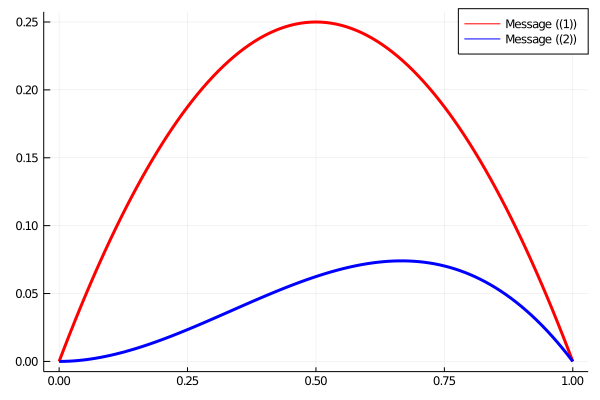

In [92]:
# Probability density function of a Beta distribution
pdfθ(θ, α, β) = beta(α,β) * θ^α * (1-θ)^β

# Extract parameters from message ((1))
α1 = messages[1].dist.params[:a]
β1 = messages[1].dist.params[:b]

# Extract parameters from message ((2))
α2 = messages[2].dist.params[:a]
β2 = messages[2].dist.params[:b]

# Plot messages
θ_range = range(0, step=0.01, stop=1.0)
plot(θ_range, pdfθ.(θ_range, α1, β1), color="red", linewidth=3, label="Message ((1))")
plot!(θ_range, pdfθ.(θ_range, α2, β2), color="blue", linewidth=3, label="Message ((2))")

The marginal distribution for $\theta$, representing the posterior $p(\theta \mid X_1)$, is obtained by taking the product of the two messages: $\overrightarrow{\mu}(\theta) \cdot \overleftarrow{\mu}(x)$. Multiplying two Beta distributions produces another Beta distribution with parameter:

$$\begin{align}
\alpha \leftarrow&\ \alpha_1 + \alpha_2 - 1 \\
\beta \leftarrow&\ \beta_1 + \beta_2 - 1 \, ,
\end{align}$$

In our case, the new parameters would be $\alpha = 1 + 2 - 1 = 2$ and $\beta = 1 + 1 - 1 = 1$. Let's check with ForneyLab what it computed as the marginal for $\theta$.

In [93]:
marginals[:θ]

Beta(a=2.00, b=1.00)


Again, ForneyLab matches our manual derivations. Let's visualize the messages as well as the marginal.

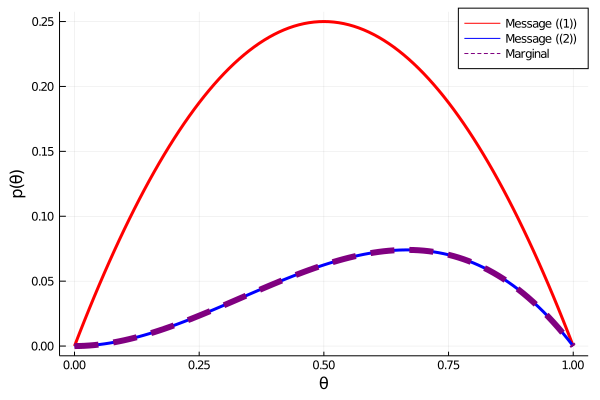

In [94]:
# Extract marginal's parameters
α_marg = marginals[:θ].params[:a]
β_marg = marginals[:θ].params[:b]

# Plot messages
θ_range = range(0, step=0.01, stop=1.0)
plot(θ_range, pdfθ.(θ_range, α1, β1), color="red", linewidth=3, label="Message ((1))")
plot!(θ_range, pdfθ.(θ_range, α2, β2), color="blue", linewidth=3, label="Message ((2))")
plot!(θ_range, pdfθ.(θ_range, α_marg, β_marg), color="purple", linewidth=6, linestyle=:dash, label="Marginal")
xlabel!("θ")
ylabel!("p(θ)")

The pdf of the marginal distribution lies on top of the pdf of Message ((2)). That's not always going to be the case; the Beta(1,1) distribution is special in that when you multiply Beta(1,1) with a general Beta(a,b) the result will always be Beta(a,b), kinda like multiplying by $1$. We call prior distributions that have this special effect "non-informative priors".

#### Multiple questions

Of course, you won't be evaluated on just a single question: it's still possible for you to get one question wrong even if you have a high skill level. You would consider it unfair to be rejected based on only one question. So, we are going to add another question. For now, this second question is also a right-or-wrong question. The outcome of this new question is denoted with variable $X_2$. The generative model is $p(X_1, X_2, \theta) = p(X_1 \mid \theta) p(X_2 \mid \theta) p(\theta)$ with the accompanying factor graph:

In [95]:
# Start building a model
factor_graph2 = FactorGraph()

# Add the prior
@RV θ ~ Beta(1.0, 1.0, id=:prior)

# Add question 1 correctness likelihood
@RV X1 ~ Bernoulli(θ, id=:likelihood1)

# Add question 2 correctness likelihood
@RV X2 ~ Bernoulli(θ, id=:likelihood2)

# The question outcomes are going to be observed
placeholder(X1, :X1)
placeholder(X2, :X2)

# Visualize the graph
ForneyLab.draw(factor_graph2)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 13691830819329180677 -->
 
 13691830819329180677 
 
 placeholder_X2 
 
<!-- 7357972311486921456 -->
 
 7357972311486921456 
 
 Ber 
 likelihood2 
 
<!-- 13691830819329180677--7357972311486921456 -->
 
 13691830819329180677--7357972311486921456 
 
 X2 
 1 out 
 1 out 
 
<!-- 10624293429816274884 -->
 
 10624293429816274884 
 
 clamp_2 
 
<!-- 9754029739773766270 -->
 
 9754029739773766270 
 
 Ber 
 likelihood1 
 
<!-- 6627729805986091299 -->
 
 6627729805986091299 
 
 = 
 equ_θ_1 
 
<!-- 6627729805986091299--7357972311486921456 -->
 
 6627729805986091299--7357972311486921456 
 
 θ 
 2 p 
 3 3 
 
<!-- 6627729805986091299--9754029739773766270 -->
 
 6627729805986091299--9754029739773766270 
 
 θ 
 2 p 
 2 2 
 
<!-- 6288206170710580622 -->
 
 6288206170710580622 
 
 Beta 
 prior 
 
<!-- 6627729805986091299--6288206170710580622 -->
 
 6627729805986091299--6288206170710580622 
 
 θ 
 1 out 
 1 1 
 
<!-- 18331317935590674055 -->
 
 18331317935590674055 
 
 placeholder_X1 
 
<!-- 18331317935590674055--9754029739773766270 -->
 
 18331317935590674055--9754029739773766270 
 
 X1 
 1 out 
 1 out 
 
<!-- 2769991813186397352 -->
 
 2769991813186397352 
 
 clamp_1 
 
<!-- 6288206170710580622--10624293429816274884 -->
 
 6288206170710580622--10624293429816274884 
 
 clamp_2 
 1 out 
 3 b 
 
<!-- 6288206170710580622--2769991813186397352 -->
 
 6288206170710580622--2769991813186397352 
 
 clamp_1 
 1 out 
 2 a

Notice that ForneyLab has generated an equality node. So, even though the model has mathematically not become much more complex (again, you've seen this in the Beer Tasting Experiment), the factor graph has. We will go through the message passing operations below. First, we generate an algorithm and visualize where all the messages for $\theta$ come from.

In [96]:
# Indicate which variables you want posteriors for
q = PosteriorFactorization(θ, ids=[:θ])

# Generate a message passing inference algorithm
algorithm = messagePassingAlgorithm(θ, q)

# Compile algorithm code
source_code = algorithmSourceCode(algorithm)

# Bring compiled code into current scope
eval(Meta.parse(source_code))

# Visualize message passing schedule
pfθ = q.posterior_factors[:θ]
ForneyLab.draw(pfθ, schedule=pfθ.schedule);

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 7357972311486921456 -->
 
 7357972311486921456 
 
 Ber 
 likelihood2 
 
<!-- 9754029739773766270 -->
 
 9754029739773766270 
 
 Ber 
 likelihood1 
 
<!-- 6627729805986091299 -->
 
 6627729805986091299 
 
 = 
 equ_θ_1 
 
<!-- 6627729805986091299--7357972311486921456 -->
 
 6627729805986091299--7357972311486921456 
 
 θ 
 2 p 
 ((3)) 
 3 3 
 
<!-- 6627729805986091299--9754029739773766270 -->
 
 6627729805986091299--9754029739773766270 
 
 θ 
 2 p 
 ((2)) 
 2 2 
 
<!-- 6288206170710580622 -->
 
 6288206170710580622 
 
 Beta 
 prior 
 
<!-- 6627729805986091299--6288206170710580622 -->
 
 6627729805986091299--6288206170710580622 
 
 θ 
 1 out 
 ((1)) 
 1 1 
 (4) 
 
<!-- 10624293429816274884 -->
 
 10624293429816274884 
 
<!-- 6288206170710580622--10624293429816274884 -->
 
 6288206170710580622--10624293429816274884 
 
 1 out 
 3 b 
 
<!-- 2769991813186397352 -->
 
 2769991813186397352 
 
<!-- 6288206170710580622--2769991813186397352 -->
 
 6288206170710580622--2769991813186397352 
 
 1 out 
 2 a 
 
<!-- 13691830819329180677 -->
 
 13691830819329180677 
 
<!-- 13691830819329180677--7357972311486921456 -->
 
 13691830819329180677--7357972311486921456 
 
 1 out 
 1 out 
 
<!-- 18331317935590674055 -->
 
 18331317935590674055 
 
<!-- 18331317935590674055--9754029739773766270 -->
 
 18331317935590674055--9754029739773766270 
 
 1 out 
 1 out

There are 

In [97]:
# Initialize a message data structure
messages = Array{Message}(undef, 4)

# Initalize marginal distributions data structure
marginals = Dict(:θ => ProbabilityDistribution(Univariate, Beta, a=1.0, b=1.0))

# Suppose you got question 1 correct
data = Dict(:X1 => 1,
            :X2 => 1)

# Update coefficients
stepθ!(data, marginals, messages);

# Print messages
print("\nMessage ((1)) = "*string(messages[1].dist))
print("Message ((2)) = "*string(messages[2].dist))
print("Message ((3)) = "*string(messages[3].dist))
println("Message ((4)) = "*string(messages[4].dist))


Message ((1)) = Beta(a=1.00, b=1.00)
Message ((2)) = Beta(a=2.00, b=1.00)
Message ((3)) = Beta(a=2.00, b=1.00)
Message ((4)) = Beta(a=3.00, b=1.00)



In [98]:
marginals[:θ]

Beta(a=3.00, b=1.00)


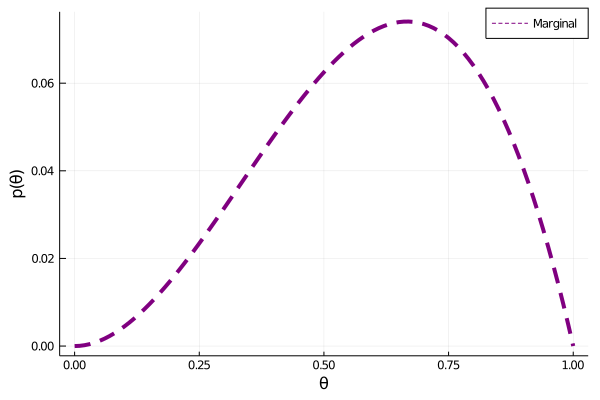

In [99]:
# Extract parameters
α = marginals[:θ].params[:a]
β = marginals[:θ].params[:b]

# Probability density function using the extracted parameters
pdfθ(θ) = beta(α,β)*θ^α*(1-θ)^β

θ_range = range(0, step=0.01, stop=1.0)
plot(θ_range, pdfθ.(θ_range, α_marg, β_marg), color="purple", linewidth=4, linestyle=:dash, label="Marginal")
xlabel!("θ")
ylabel!("p(θ)")

### 2. Score questions

So far, the models we have been looking at have been quite simple; they are essentially the same as the one in the Beer Tasting Experiment. We will now move to slightly more complicated distributions. These will enrich your toolbox and allow you to do much more.



In [100]:
# Start building a model
factor_graph3 = FactorGraph()

# Add the prior
@RV θ ~ Dirichlet([1.0, 1.0, 1.0], id=:prior)

# Add question 1 correctness likelihood
@RV X1 ~ Categorical(θ, id=:likelihood1)

# Add question 2 correctness likelihood
@RV X2 ~ Categorical(θ, id=:likelihood2)

# The question outcomes are going to be observed
placeholder(X1, dims=(3,), :X1)
placeholder(X2, dims=(3,), :X2)

# Visualize the graph
ForneyLab.draw(factor_graph3)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 2405653087362892964 -->
 
 2405653087362892964 
 
 placeholder_X1 
 
<!-- 8869700740449845262 -->
 
 8869700740449845262 
 
 Cat 
 likelihood1 
 
<!-- 2405653087362892964--8869700740449845262 -->
 
 2405653087362892964--8869700740449845262 
 
 X1 
 1 out 
 1 out 
 
<!-- 12110628886802914578 -->
 
 12110628886802914578 
 
 = 
 equ_θ_1 
 
<!-- 12110628886802914578--8869700740449845262 -->
 
 12110628886802914578--8869700740449845262 
 
 θ 
 2 p 
 2 2 
 
<!-- 245793994652001139 -->
 
 245793994652001139 
 
 Cat 
 likelihood2 
 
<!-- 12110628886802914578--245793994652001139 -->
 
 12110628886802914578--245793994652001139 
 
 θ 
 2 p 
 3 3 
 
<!-- 16919381594139164229 -->
 
 16919381594139164229 
 
 Dir 
 prior 
 
<!-- 12110628886802914578--16919381594139164229 -->
 
 12110628886802914578--16919381594139164229 
 
 θ 
 1 out 
 1 1 
 
<!-- 6322676639814482385 -->
 
 6322676639814482385 
 
 clamp_1 
 
<!-- 16919381594139164229--6322676639814482385 -->
 
 16919381594139164229--6322676639814482385 
 
 clamp_1 
 1 out 
 2 a 
 
<!-- 630126952980572127 -->
 
 630126952980572127 
 
 placeholder_X2 
 
<!-- 630126952980572127--245793994652001139 -->
 
 630126952980572127--245793994652001139 
 
 X2 
 1 out 
 1 out

In [101]:
# Indicate which variables you want posteriors for
q = PosteriorFactorization(θ, ids=[:θ])

# Generate a message passing inference algorithm
algorithm = messagePassingAlgorithm(θ, q)

# Compile algorithm code
source_code = algorithmSourceCode(algorithm)

# Bring compiled code into current scope
eval(Meta.parse(source_code))
println(source_code)

# Visualize message passing schedule
pfθ = q.posterior_factors[:θ]
ForneyLab.draw(pfθ, schedule=pfθ.schedule);

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 12110628886802914578 -->
 
 12110628886802914578 
 
 = 
 equ_θ_1 
 
<!-- 8869700740449845262 -->
 
 8869700740449845262 
 
 Cat 
 likelihood1 
 
<!-- 12110628886802914578--8869700740449845262 -->
 
 12110628886802914578--8869700740449845262 
 
 θ 
 2 p 
 ((2)) 
 2 2 
 
<!-- 245793994652001139 -->
 
 245793994652001139 
 
 Cat 
 likelihood2 
 
<!-- 12110628886802914578--245793994652001139 -->
 
 12110628886802914578--245793994652001139 
 
 θ 
 2 p 
 ((3)) 
 3 3 
 
<!-- 16919381594139164229 -->
 
 16919381594139164229 
 
 Dir 
 prior 
 
<!-- 12110628886802914578--16919381594139164229 -->
 
 12110628886802914578--16919381594139164229 
 
 θ 
 1 out 
 ((1)) 
 1 1 
 (4) 
 
<!-- 6322676639814482385 -->
 
 6322676639814482385 
 
<!-- 16919381594139164229--6322676639814482385 -->
 
 16919381594139164229--6322676639814482385 
 
 1 out 
 2 a 
 
<!-- 2405653087362892964 -->
 
 2405653087362892964 
 
<!-- 2405653087362892964--8869700740449845262 -->
 
 2405653087362892964--8869700740449845262 
 
 1 out 
 1 out 
 
<!-- 630126952980572127 -->
 
 630126952980572127 
 
<!-- 630126952980572127--245793994652001139 -->
 
 630126952980572127--245793994652001139 
 
 1 out 
 1 out

begin

function stepθ!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 4))

messages[1] = ruleVBDirichletOut(nothing, ProbabilityDistribution(Multivariate, PointMass, m=[1.0, 1.0, 1.0]))
messages[2] = ruleVBCategoricalIn1(ProbabilityDistribution(Multivariate, PointMass, m=data[:X1]), nothing)
messages[3] = ruleVBCategoricalIn1(ProbabilityDistribution(Multivariate, PointMass, m=data[:X2]), nothing)
messages[4] = ruleSPEqualityDirichlet(nothing, messages[2], messages[3])

marginals[:θ] = messages[1].dist * messages[4].dist

return marginals

end

end # block


In [102]:
# Initialize a message data structure
messages = Array{Message}(undef, 4)

# Initalize marginal distributions data structure
marginals = Dict(:θ => ProbabilityDistribution(Dirichlet, a=[1.0, 1.0, 1.0]))

# Suppose you got question 1 correct
data = Dict(:X1 => [1, 0, 0],
            :X2 => [0, 1, 0])

# Update coefficients
stepθ!(data, marginals, messages);

# Print messages
print("\nMessage ((1)) = "*string(messages[1].dist))
print("Message ((2)) = "*string(messages[2].dist))
print("Message ((3)) = "*string(messages[3].dist))
println("Message ((4)) = "*string(messages[4].dist))


Message ((1)) = Dir(a=[1.00, 1.00, 1.00])
Message ((2)) = Dir(a=[2.00, 1.00, 1.00])
Message ((3)) = Dir(a=[1.00, 2.00, 1.00])
Message ((4)) = Dir(a=[2.00, 2.00, 1.00])



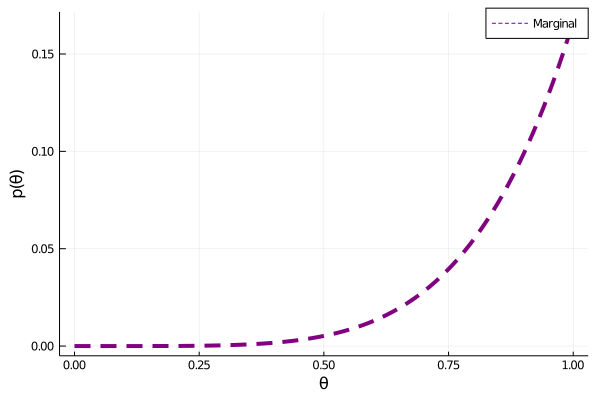

In [103]:
# Extract parameters
α = marginals[:θ].params[:a]

# Probability density function using the extracted parameters
pdfθ(θ) = prod(gamma.(α))/gamma(prod(α)) * prod(θ.^α)

# Visualizations are more difficult for a Dirichlet
θ_range = range(0, step=0.01, stop=1.0)
plot(θ_range, pdfθ.(θ_range), color="purple", linewidth=4, linestyle=:dash, label="Marginal")
xlabel!("θ")
ylabel!("p(θ)")

### 3. Rating scale

In [104]:
# Start building a model
factor_graph4 = FactorGraph()

# Add the prior
@RV θ ~ GaussianMeanVariance(3., 1., id=:prior)

# Add question 1 correctness likelihood
@RV X1 ~ GaussianMeanVariance(θ, 0.5, id=:likelihood1)

# Add question 2 correctness likelihood
@RV X2 ~ GaussianMeanVariance(θ, 0.5, id=:likelihood2)

# The question outcomes are going to be observed
placeholder(X1, :X1)
placeholder(X2, :X2)

# Visualize the graph
ForneyLab.draw(factor_graph4)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 3244190044878345447 -->
 
 3244190044878345447 
 
 = 
 equ_θ_1 
 
<!-- 9351195520394461077 -->
 
 9351195520394461077 
 
 𝒩 
 likelihood2 
 
<!-- 3244190044878345447--9351195520394461077 -->
 
 3244190044878345447--9351195520394461077 
 
 θ 
 2 m 
 3 3 
 
<!-- 1788988844381638675 -->
 
 1788988844381638675 
 
 𝒩 
 likelihood1 
 
<!-- 3244190044878345447--1788988844381638675 -->
 
 3244190044878345447--1788988844381638675 
 
 θ 
 2 m 
 2 2 
 
<!-- 3144366550246968318 -->
 
 3144366550246968318 
 
 𝒩 
 prior 
 
<!-- 3244190044878345447--3144366550246968318 -->
 
 3244190044878345447--3144366550246968318 
 
 θ 
 1 out 
 1 1 
 
<!-- 6789306046249429103 -->
 
 6789306046249429103 
 
 clamp_4 
 
<!-- 9351195520394461077--6789306046249429103 -->
 
 9351195520394461077--6789306046249429103 
 
 clamp_4 
 1 out 
 3 v 
 
<!-- 5048019114141358341 -->
 
 5048019114141358341 
 
 clamp_1 
 
<!-- 8662397501734191085 -->
 
 8662397501734191085 
 
 clamp_3 
 
<!-- 1788988844381638675--8662397501734191085 -->
 
 1788988844381638675--8662397501734191085 
 
 clamp_3 
 1 out 
 3 v 
 
<!-- 14887027335380175485 -->
 
 14887027335380175485 
 
 placeholder_X1 
 
<!-- 14887027335380175485--1788988844381638675 -->
 
 14887027335380175485--1788988844381638675 
 
 X1 
 1 out 
 1 out 
 
<!-- 14305097120195438784 -->
 
 14305097120195438784 
 
 placeholder_X2 
 
<!-- 14305097120195438784--9351195520394461077 -->
 
 14305097120195438784--9351195520394461077 
 
 X2 
 1 out 
 1 out 
 
<!-- 3144366550246968318--5048019114141358341 -->
 
 3144366550246968318--5048019114141358341 
 
 clamp_1 
 1 out 
 2 m 
 
<!-- 4568934371250876219 -->
 
 4568934371250876219 
 
 clamp_2 
 
<!-- 3144366550246968318--4568934371250876219 -->
 
 3144366550246968318--4568934371250876219 
 
 clamp_2 
 1 out 
 3 v

In [105]:
# Indicate which variables you want posteriors for
q = PosteriorFactorization(θ, ids=[:θ])

# Generate a message passing inference algorithm
algorithm = messagePassingAlgorithm(θ, q)

# Compile algorithm code
source_code = algorithmSourceCode(algorithm)

# Bring compiled code into current scope
eval(Meta.parse(source_code))
println(source_code)

# Visualize message passing schedule
pfθ = q.posterior_factors[:θ]
ForneyLab.draw(pfθ, schedule=pfθ.schedule);

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 9351195520394461077 -->
 
 9351195520394461077 
 
 𝒩 
 likelihood2 
 
<!-- 6789306046249429103 -->
 
 6789306046249429103 
 
<!-- 9351195520394461077--6789306046249429103 -->
 
 9351195520394461077--6789306046249429103 
 
 1 out 
 3 v 
 
<!-- 1788988844381638675 -->
 
 1788988844381638675 
 
 𝒩 
 likelihood1 
 
<!-- 8662397501734191085 -->
 
 8662397501734191085 
 
<!-- 1788988844381638675--8662397501734191085 -->
 
 1788988844381638675--8662397501734191085 
 
 1 out 
 3 v 
 
<!-- 3144366550246968318 -->
 
 3144366550246968318 
 
 𝒩 
 prior 
 
<!-- 4568934371250876219 -->
 
 4568934371250876219 
 
<!-- 3144366550246968318--4568934371250876219 -->
 
 3144366550246968318--4568934371250876219 
 
 1 out 
 3 v 
 
<!-- 5048019114141358341 -->
 
 5048019114141358341 
 
<!-- 3144366550246968318--5048019114141358341 -->
 
 3144366550246968318--5048019114141358341 
 
 1 out 
 2 m 
 
<!-- 3244190044878345447 -->
 
 3244190044878345447 
 
 = 
 equ_θ_1 
 
<!-- 3244190044878345447--9351195520394461077 -->
 
 3244190044878345447--9351195520394461077 
 
 θ 
 2 m 
 ((3)) 
 3 3 
 
<!-- 3244190044878345447--1788988844381638675 -->
 
 3244190044878345447--1788988844381638675 
 
 θ 
 2 m 
 ((2)) 
 2 2 
 
<!-- 3244190044878345447--3144366550246968318 -->
 
 3244190044878345447--3144366550246968318 
 
 θ 
 1 out 
 ((1)) 
 1 1 
 (4) 
 
<!-- 14887027335380175485 -->
 
 14887027335380175485 
 
<!-- 14887027335380175485--1788988844381638675 -->
 
 14887027335380175485--1788988844381638675 
 
 1 out 
 1 out 
 
<!-- 14305097120195438784 -->
 
 14305097120195438784 
 
<!-- 14305097120195438784--9351195520394461077 -->
 
 14305097120195438784--9351195520394461077 
 
 1 out 
 1 out

begin

function stepθ!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 4))

messages[1] = ruleVBGaussianMeanVarianceOut(nothing, ProbabilityDistribution(Univariate, PointMass, m=3.0), ProbabilityDistribution(Univariate, PointMass, m=1.0))
messages[2] = ruleVBGaussianMeanVarianceM(ProbabilityDistribution(Univariate, PointMass, m=data[:X1]), nothing, ProbabilityDistribution(Univariate, PointMass, m=0.5))
messages[3] = ruleVBGaussianMeanVarianceM(ProbabilityDistribution(Univariate, PointMass, m=data[:X2]), nothing, ProbabilityDistribution(Univariate, PointMass, m=0.5))
messages[4] = ruleSPEqualityGaussian(nothing, messages[2], messages[3])

marginals[:θ] = messages[1].dist * messages[4].dist

return marginals

end

end # block


In [106]:
# Initialize a message data structure
messages = Array{Message}(undef, 4)

# Initalize marginal distributions data structure
marginals = Dict(:θ => ProbabilityDistribution(Univariate, GaussianMeanVariance, m=0.0, v=1.0))

# Suppose you got question 1 correct
data = Dict(:X1 => 3.2,
            :X2 => 4.5)

# Update coefficients
stepθ!(data, marginals, messages);

# Print messages
print("\nMessage ((1)) = "*string(messages[1].dist))
print("Message ((2)) = "*string(messages[2].dist))
print("Message ((3)) = "*string(messages[3].dist))
println("Message ((4)) = "*string(messages[4].dist))


Message ((1)) = 𝒩(m=3.00, v=1.00)
Message ((2)) = 𝒩(m=3.20, v=0.50)
Message ((3)) = 𝒩(m=4.50, v=0.50)
Message ((4)) = 𝒩(xi=15.40, w=4.00)



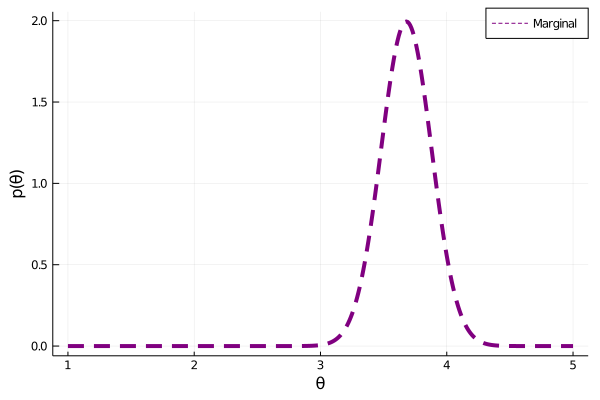

In [107]:
# Extract parameters
m = mean(marginals[:θ])
v = var(marginals[:θ])

# Probability density function using the extracted parameters
pdfθ(θ) = 1/sqrt(2*π*v^2)*exp(-(θ - m)^2/(2*v^2))

# Visualizations are more difficult for a Dirichlet
θ_range = range(1.0, step=0.01, stop=5.0)
plot(θ_range, pdfθ.(θ_range), color="purple", linewidth=4, linestyle=:dash, label="Marginal")
xlabel!("θ")
ylabel!("p(θ)")